# Amazon Reviews Analysis

### Installing Dependencies

Before running the project, we need to install the required dependencies. The following command installs all necessary packages listed in the `requirements.txt` file.

In [25]:
!pip install -r requirements.txt

## Data Preprocessing

In this section, we initialize and use the `ReviewCleaner` class, which is responsible for loading, parsing, and cleaning product review data. The class extracts and preprocesses review information from a gzipped file. After loading the data, we clean it by removing missing values, duplicates, and irrelevant data. 

The following steps will:
1. Load the raw review data.
2. Clean the reviews by handling missing values and duplicates.
3. Provide a cleaned dataset for further analysis.

In [1]:
from config import BaseConfig as config
from src import ReviewCleaner

rev_cleaner = ReviewCleaner(config.SOURCE_DATA)
rev_cleaner.load_reviews()
reviews = rev_cleaner.clean_reviews()

/home/wiktor/projects/AmazonReviews/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Overview

In [2]:
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 76415 entries, 46588 to 71846
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     76415 non-null  object 
 1   product_title  76415 non-null  object 
 2   product_price  35270 non-null  float64
 3   user_id        76415 non-null  object 
 4   profile_name   76415 non-null  object 
 5   helpfulness    76415 non-null  float64
 6   score          76415 non-null  float64
 7   time           76415 non-null  Int64  
 8   summary        76415 non-null  object 
 9   text           76415 non-null  object 
dtypes: Int64(1), float64(3), object(6)
memory usage: 6.5+ MB
None



The `reviews` DataFrame contains 76,415 entries with 10 columns. Here's a quick summary of the columns:
- **product_id**: Product identifier (object type).
- **product_title**: Title of the product (object type).
- **product_price**: Price of the product (float64).
- **user_id**: User identifier (object type).
- **profile_name**: Profile name of the reviewer (object type).
- **helpfulness**: Helpfulness score (float64).
- **score**: Rating score (float64).
- **time**: Review timestamp (Int64).
- **summary**: Review summary (object type).
- **text**: Full review text (object type).

In [3]:
print(reviews.isna().sum())

product_id           0
product_title        0
product_price    41145
user_id              0
profile_name         0
helpfulness          0
score                0
time                 0
summary              0
text                 0
dtype: int64


The **product_price** column contains a significant amount of missing values: more than 50% of the data is missing. Given the large proportion of missing entries, we will leave the column as it is for now.

In [4]:
print(reviews.head().to_markdown())

|       | product_id   | product_title                                                                                                                                                                             |   product_price | user_id               | profile_name    |   helpfulness |   score |       time | summary        | text                                                                                                                                                                                                                                                                   |
|------:|:-------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:----------------------|:----------------|--------------:|--------:|-----------:|:---------------|:-----------------------------------------------------------------------------

## Exploratory Data Analysis

In this cell, we import essential libraries for data manipulation and visualization:
- **pandas**: For handling and processing the dataset.
- **matplotlib.pyplot** and **seaborn**: For creating visualizations such as plots and graphs.
- **plt.style.use('ggplot')**: Sets the default plotting style to 'ggplot', which provides a clean and aesthetically pleasing appearance for plots.

Additionally, we import **BaseConfig** from the **config** file, which contains configuration settings for the project.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('ggplot')

### Analysis of Review Scores

This cell sorts the reviews by their score and visualizes the distribution of review scores using a histogram. 

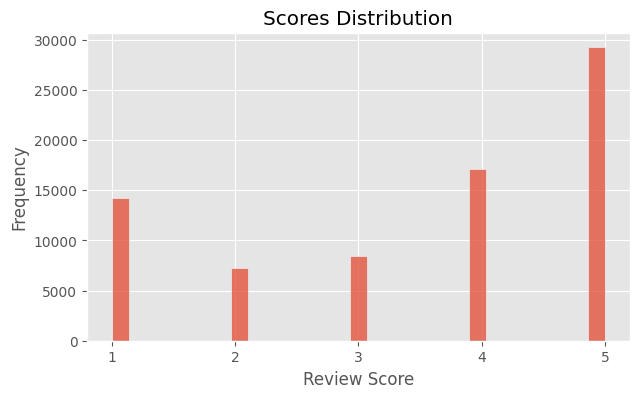

In [6]:
reviews = reviews.sort_values(by='score', ascending=True)
plt.figure(figsize=(7, 4))
sns.histplot(reviews['score'])
plt.title('Scores Distribution')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.show()

The distribution shows that the majority of reviews are 5-star, comprising nearly 50% of the dataset. There are also significant amounts of 4-star and 1-star reviews, while 2-star and 3-star reviews are less frequent.

### Distribution of Review Counts per User

The histogram illustrates the distribution of review counts per user. The y-axis is shown on a logarithmic scale to highlight the skewness of the data.


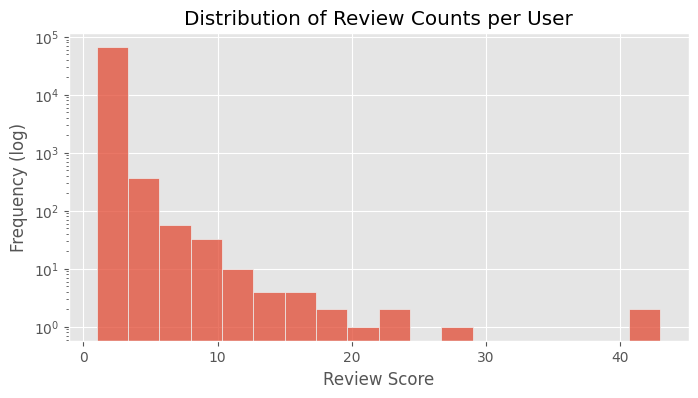

In [7]:
user_reviews = reviews.groupby(by='user_id')['user_id'].count()
user_reviews = user_reviews.sort_values(ascending=True)

plt.figure(figsize=(8, 4))
sns.histplot(user_reviews)
plt.title('Distribution of Review Counts per User')
plt.ylabel('Frequency (log)')
plt.xlabel('Review Score')
plt.yscale('log')
plt.show()

Most users have submitted only a few reviews, with a small number of users contributing significantly more. The dominant number is 1 review per user. This distribution follows a power-law pattern, where the majority of users submit very few reviews, while a small group of users dominate the dataset with a large number of reviews.

This plot shows the distribution of review counts per product. The x-axis represents products, while the y-axis shows the log-transformed review count.

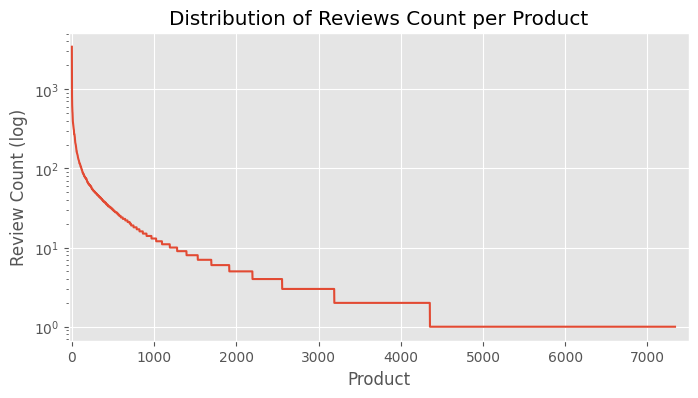

In [8]:
product_reviews = reviews.groupby(by='product_id')['product_id'].count()
product_reviews = product_reviews.sort_values(ascending=False)

plt.figure(figsize=(8, 4))
plt.plot(product_reviews.values)
plt.xlim(-40, 7500)
plt.yscale('log')
plt.title('Distribution of Reviews Count per Product')
plt.xlabel('Product')
plt.ylabel('Review Count (log)')
plt.show()

The graph indicates a skewed distribution, where a small number of products have a significantly higher number of reviews, while most products have relatively few reviews.

This set of scatter plots illustrates the relationship between product price and the number of reviews for each star rating (1 to 5 stars). Each plot displays a log-log scale, showing how the number of reviews varies with price across different score categories.

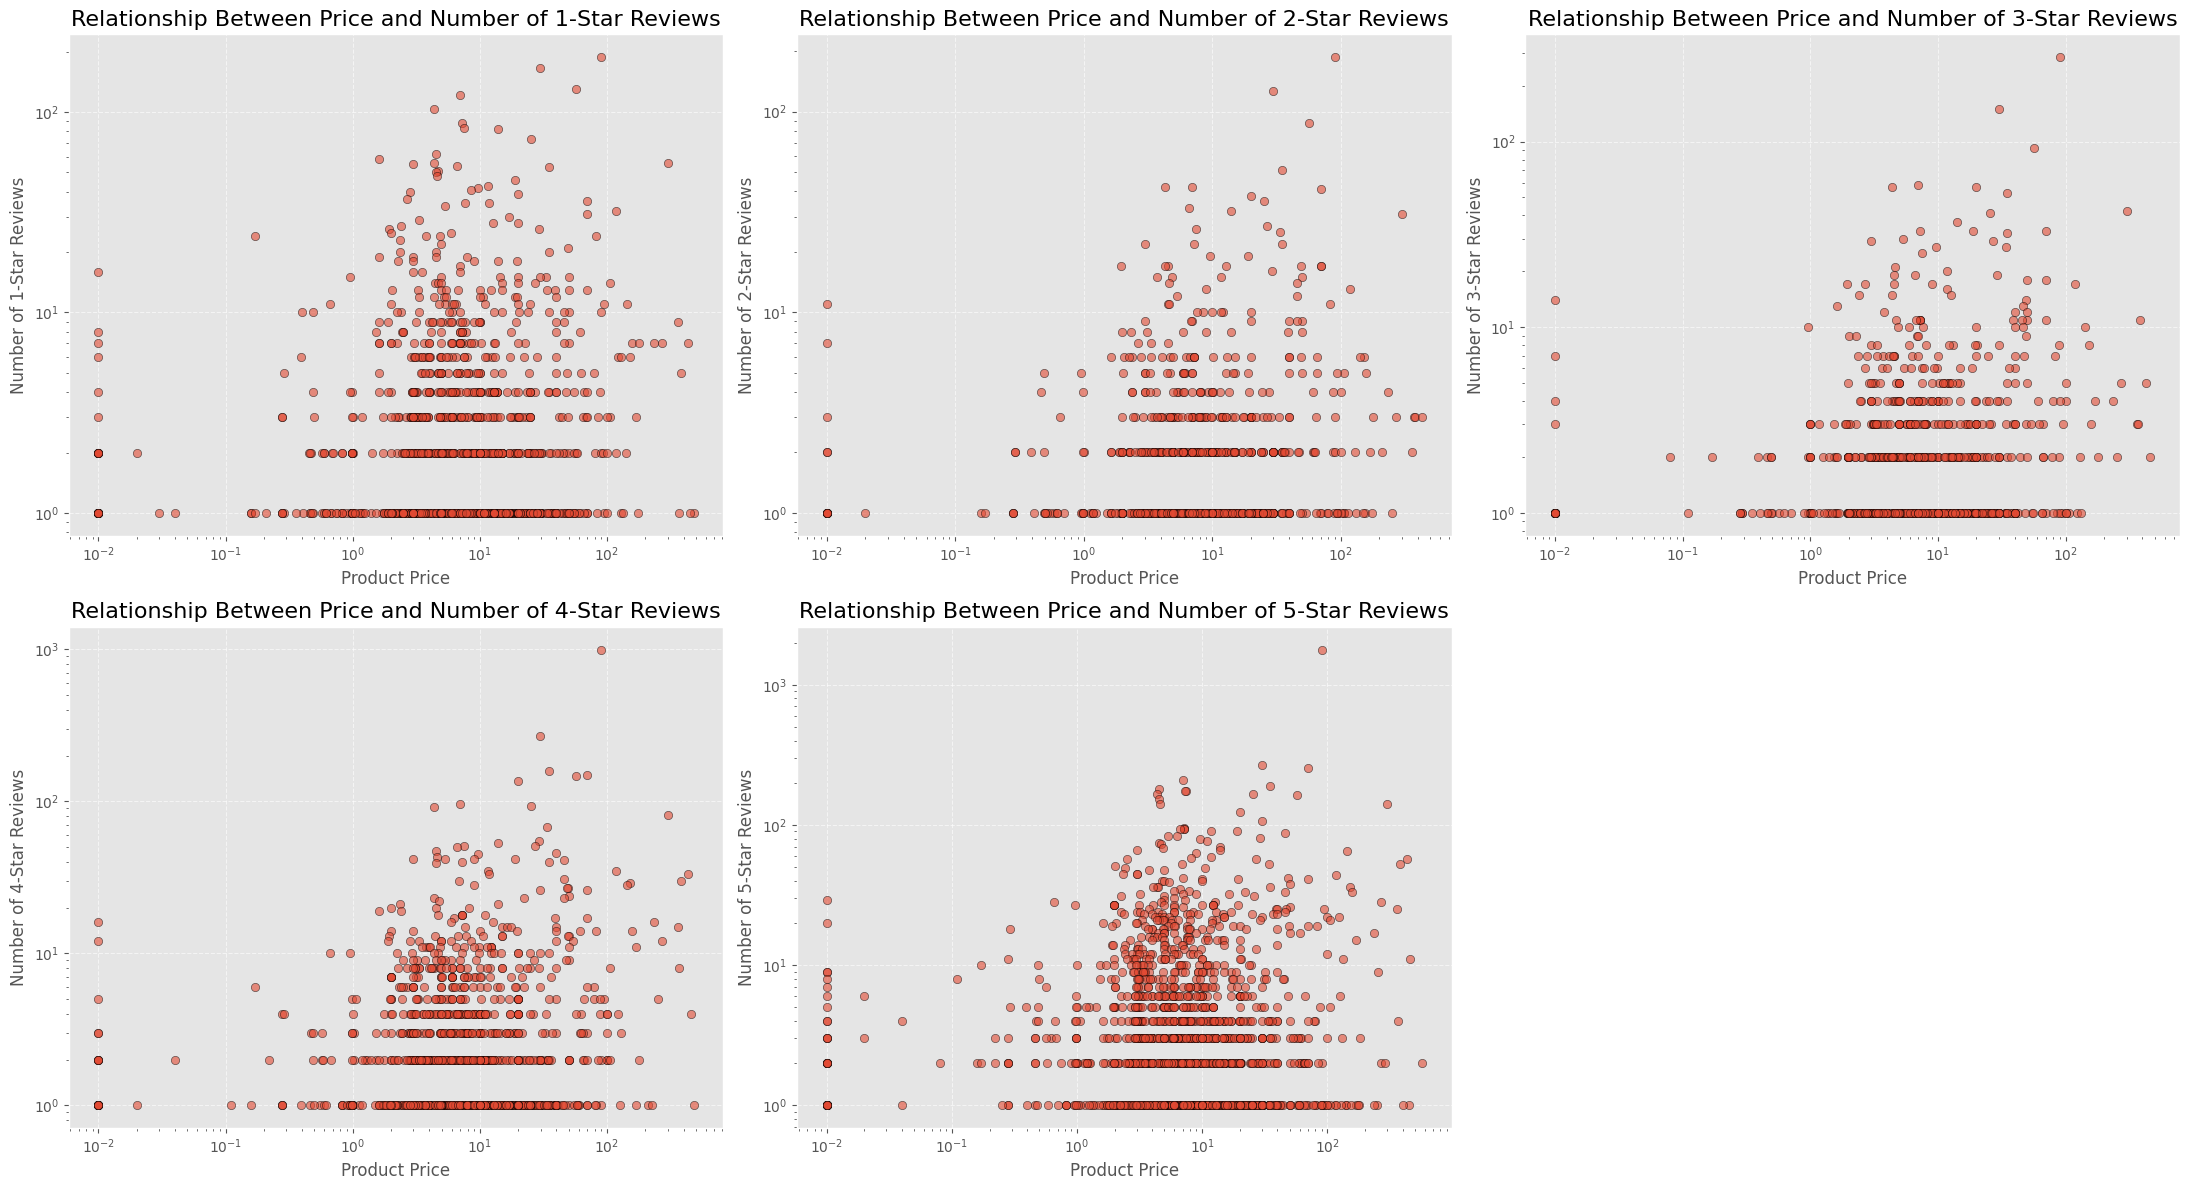

In [9]:
cleaned_price = reviews[reviews['product_price'] != 'unknown']
price_info = reviews[['product_id', 'product_price']].drop_duplicates()

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

for i, score in enumerate(reviews['score'].unique()):
    only_one_score = cleaned_price[cleaned_price['score'] == score]
    only_one_score = only_one_score.groupby(by='product_id').size().reset_index(name='count')
    
    merged_df = pd.merge(price_info, only_one_score, 'right', 'product_id')
    merged_df = merged_df.sort_values(by='count', ascending=False)

    sns.scatterplot(data=merged_df, x='product_price', y='count', alpha=0.6, edgecolor='k', ax=axes[i])

    axes[i].set_title(f'Relationship Between Price and Number of {int(score)}-Star Reviews', fontsize=16)
    axes[i].set_xlabel('Product Price', fontsize=12)
    axes[i].set_ylabel(f'Number of {int(score)}-Star Reviews', fontsize=12)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

We can see once again that the number of 5-star reviews is higher than the others. The most popular products are priced between $7 and $12, with extremely cheap products also receiving a significant number of reviews, but to a lesser extent. The number of 4-star and 5-star reviews slightly increases with price. This suggests that price may have some influence on the quality of reviews, but the relationship isn't straightforward. Other factors, such as popularity, sales region, and more, likely play a significant role in customer ratings.

## Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import BaseConfig as config

plt.style.use('ggplot')

In this step, we perform sentiment analysis on the review texts using the pretrained **DistilBERT** model - **distilbert-base-uncased-finetuned-sst-2-english**. This model classifies each review as either positive or negative. 

In [ ]:
from src import SentimentAnalysis

sentiment_analysis = SentimentAnalysis(device=config.DEVICE, model_name=config.SENTIMENT_MODEL, df=reviews)
sentiment = sentiment_analysis.predict(batch_size=64)

# Save the results to a CSV file in case of losing session variables
sentiment.to_csv(config.SENTIMENT_CSV, index=False)

Processing batches: 100%|██████████| 4776/4776 [15:09<00:00,  5.25batch/s]


In [4]:
sentiment = pd.read_csv(config.SENTIMENT_CSV) 
print(sentiment[['sentiment', 'confidence']].iloc[:10].to_markdown())

|    | sentiment   |   confidence |
|---:|:------------|-------------:|
|  0 | POSITIVE    |     0.999853 |
|  1 | NEGATIVE    |     0.996752 |
|  2 | NEGATIVE    |     0.994993 |
|  3 | POSITIVE    |     0.997699 |
|  4 | POSITIVE    |     0.97039  |
|  5 | NEGATIVE    |     0.998664 |
|  6 | NEGATIVE    |     0.997326 |
|  7 | NEGATIVE    |     0.986514 |
|  8 | POSITIVE    |     0.835932 |
|  9 | POSITIVE    |     0.988852 |


After executing the sentiment analysis, we have added two new columns to the review dataset: sentiment and confidence. The sentiment column indicates whether the review is classified as 'POSITIVE' or 'NEGATIVE', while the confidence column provides the model's confidence level in the classification. 

- **sentiment**: Sentiment statement (object type).
- **confidence**: Probability score of the sentiment (float type).

### Sentiment Distribution

The following visualization presents the distribution of sentiment classifications in the dataset. It highlights the number of **positive** and **negative** reviews.


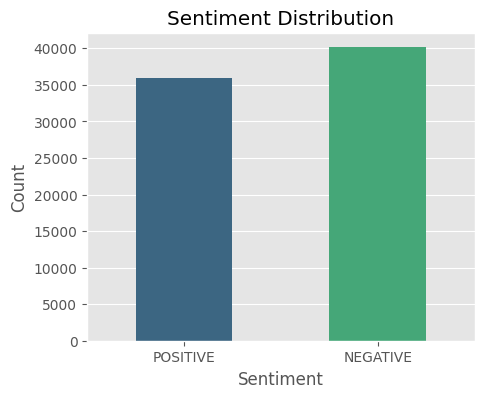

In [162]:
plt.figure(figsize=(5, 4))
sns.countplot(data=sentiment, x='sentiment', hue='sentiment', width=0.5, palette='viridis', label=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

The number of negative reviews is higher than positive ones, but not significantly.

### Review Length and Sentiment Confidence  

The plot below illustrates how the length of reviews relates to sentiment confidence, showing patterns for both positive and negative sentiments.

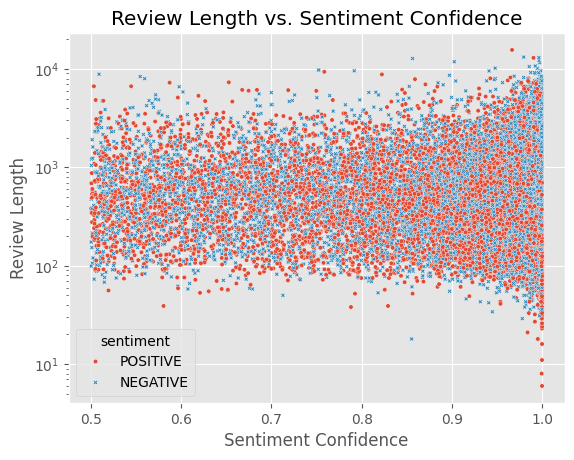

In [163]:
sentiment['review_length'] = sentiment['text'].str.len()

sns.scatterplot(data=sentiment, x='confidence', y='review_length', hue='sentiment', s=10, style='sentiment')
plt.xlabel('Sentiment Confidence')
plt.ylabel('Review Length')
plt.title('Review Length vs. Sentiment Confidence')
plt.yscale('log')
plt.show()

It is difficult to determine whether review length impacts sentiment confidence. A large number of reviews receive high confidence regardless of their length. However, there is a slight difference in very short reviews (10-100 characters), which tend to have high positive confidence. This may suggest that when users dislike a product, they are more likely to describe the issue in detail.

### Sentiment Confidence Across Ratings

This visualization illustrates how sentiment confidence varies across different review scores. It provides insights into how strongly the sentiment model associates confidence with positive and negative reviews at each rating level.

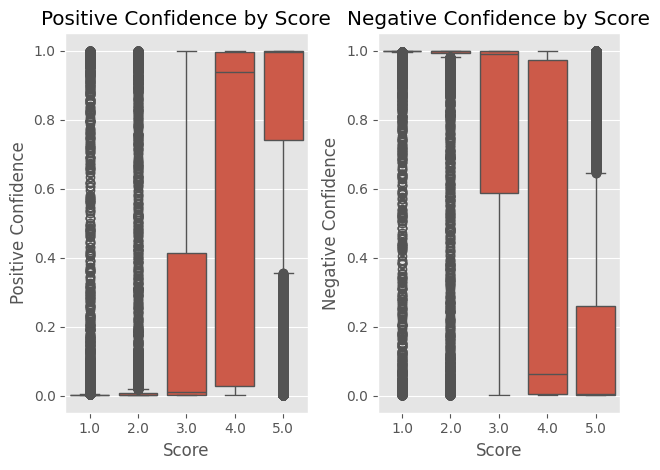

In [ ]:
sentiment['positive_confidence'] = sentiment['confidence'].where(sentiment['sentiment'] == 'POSITIVE', 1 - sentiment['confidence'])
sentiment['negative_confidence'] = 1 - sentiment['positive_confidence']

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
sns.boxplot(data=sentiment, x='score', y='positive_confidence', ax=axes[0])
axes[0].set_title('Positive Confidence by Score')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Positive Confidence')

sns.boxplot(data=sentiment, x='score', y='negative_confidence', ax=axes[1])
axes[1].set_title('Negative Confidence by Score')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Negative Confidence')

plt.tight_layout()
plt.show()

The easiest scores for the model to differentiate are the 1- and 2-star reviews, as these are unambiguous. Next, we have 5-star reviews, where the model mostly predicts correctly (the 50th percentile is close to a value of 1), but there is a group of reviews that are misclassified or have lower confidence scores. Then, we have 4-star reviews, where the confidence is spread across all values, but most of them still have a high confidence score. Finally, there are 3-star reviews, which tend to have higher negative coefficient scores.

Generally, this indicates that the model may have difficulty classifying ambiguous reviews as either positive or negative, as they contain some dissatisfaction. In the case of 4-star reviews, the model makes mistakes, possibly due to some user dissatisfaction, as the reviewer did not give a 5-star rating. To improve model performance, adding a new class, such as "neutral," could be a good solution.

### Helpfulness by Sentiment

In this visualization, we will explore how the "helpfulness" score is distributed across different sentiment categories (positive, negative). The violin plot will show the distribution of helpfulness scores for each sentiment category.

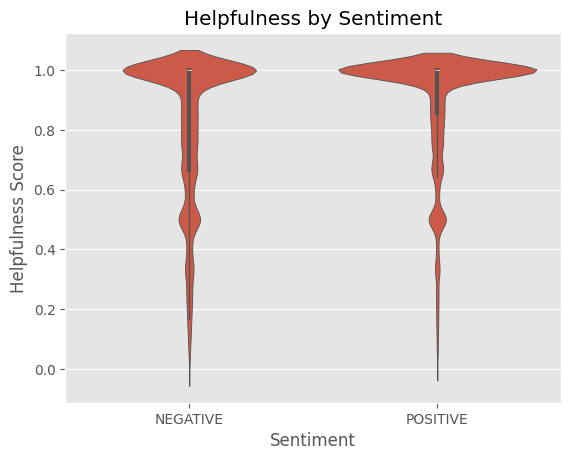

In [165]:
cleaned_helpfulness = sentiment[sentiment['helpfulness'] != 0]

sns.violinplot(data=cleaned_helpfulness, x='sentiment', y='helpfulness')

plt.title('Helpfulness by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Helpfulness Score')
plt.show()


The difference between these violins lies in how they are thin at different layers. Both of them have a significant impact, and many other users appreciate their opinions, which is why they have the highest helpfulness scores. In the case of positive reviews, there is a larger group of users who were satisfied.

Generally, this means that many users value the helpfulness of reviews when shopping, and people tend to pay more attention to positive reviews than negative ones.

## Product Titles Clustering

In this section, we perform clustering on the product titles based on their semantic embeddings. The `TitleClustering` class utilizes a pre-trained `SBERT` model (`sentence-transformers/all-MiniLM-L6-v2`) to encode the titles. Dimensionality reduction is then applied using PCA to reduce the embeddings to two dimensions, facilitating better visualization, computation, and clustering.

The process includes the following steps:
1. **Encoding the Titles**: Using the `SentenceTransformer` model to encode product titles into semantic embeddings.
2. **Dimensionality Reduction**: Applying PCA to reduce the embeddings to 2 dimensions for easier visualization.
3. **Normalizing Data**: Applying `StandardScaler` to normalize the embeddings, ensuring that each feature has a mean of 0 and a standard deviation of 1.
4. **Clustering**: Grouping similar product titles into clusters based on their embeddings using the `KMeans` algorithm.

This allows us to explore the product titles in a reduced space and identify potential clusters of similar products.

In [ ]:
from src import TitleClustering

products = sentiment['product_title'].drop_duplicates()

title_clustering = TitleClustering(config.DEVICE, config.EMBEDDING_MODEL, products)
embeddings = title_clustering.encode()
features = title_clustering.reduce_dimensions(embeddings, n_components=2)

Running K-Means: 100%|██████████| 20/20 [00:05<00:00,  3.46cluster/s]


### Determining the Optimal Number of Clusters Using the Elbow Method

So far, we have applied the first three steps: encoding the titles, reducing the dimensions, and normalizing the data. Now, it's time to perform clustering. However, before we can proceed, we need to determine the optimal number of clusters for the KMeans algorithm. 

One way to achieve this is by using the **Elbow Method**, which helps us identify the value of `k` (the number of clusters) that minimizes the Within-Cluster Sum of Squares (WCSS) while avoiding overfitting. The plot below will visualize the WCSS for different values of `k` and help us select the optimal number of clusters based on the "elbow" point.

Running K-Means: 100%|██████████| 15/15 [00:04<00:00,  3.51cluster/s]


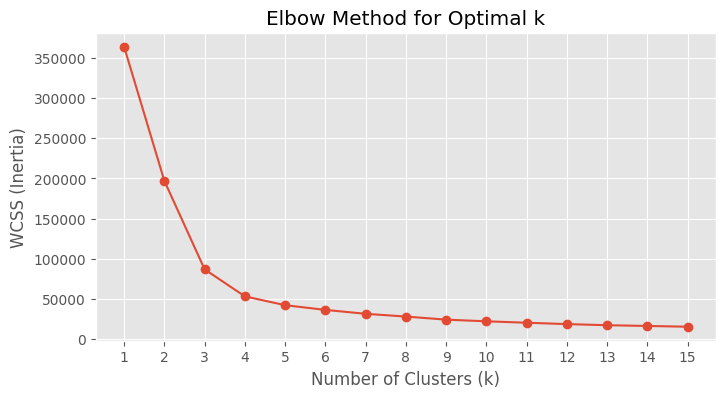

In [ ]:
wcss = title_clustering.elbow_method(embeddings=features, max_clusters=15)
cluster_range = range(1, len(wcss) + 1)

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

The optimal point for our dataset appears to be 4, as the curve of the WCSS value begins to flatten in this region. This suggests that adding more clusters beyond this point does not significantly improve the model’s performance, making 4 the ideal choice for the number of clusters.

### Performing Clustering and Visualizing the Cluster Distribution

Now that we have determined the optimal number of clusters (4) using the elbow method, we can proceed with clustering the product titles.

Once the clustering is complete, we will visualize the distribution of the clusters in a 2D space using a scatter plot. The plot will display the products in their reduced 2D embeddings, with different colors representing different clusters.

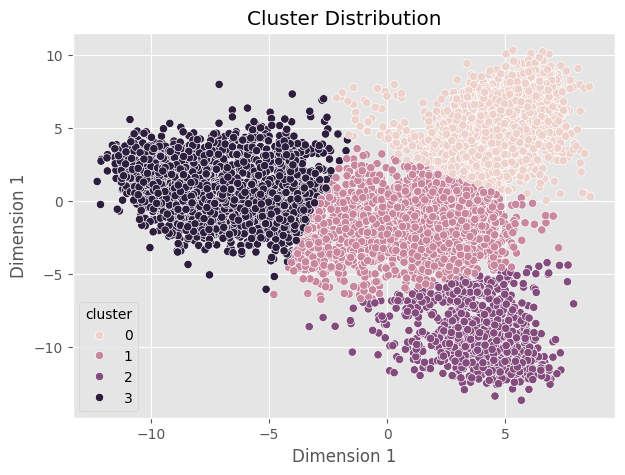

In [ ]:

clusters = title_clustering.clustering(embeddings=features, n_clusters=4)
products = title_clustering.combine_results(features=features, clusters=clusters)

plt.figure(figsize=(7, 5))
sns.scatterplot(data=products, x='dim_0', y='dim_1', hue='cluster')
plt.title('Cluster Distribution')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 1')
plt.grid(True)
plt.show()

These results still don’t provide us with a lot of information, but we can already see that the model has performed well. By examining the clusters, we can gain insights into how similar products are grouped together based on their titles.

### Visualizing the Distribution of Products Across Clusters

Now that we have performed clustering and assigned product titles to different clusters, it's important to visualize the distribution of products in each cluster. The following bar plot will display the number of products in each cluster, providing insights into how well the data is distributed across the clusters.

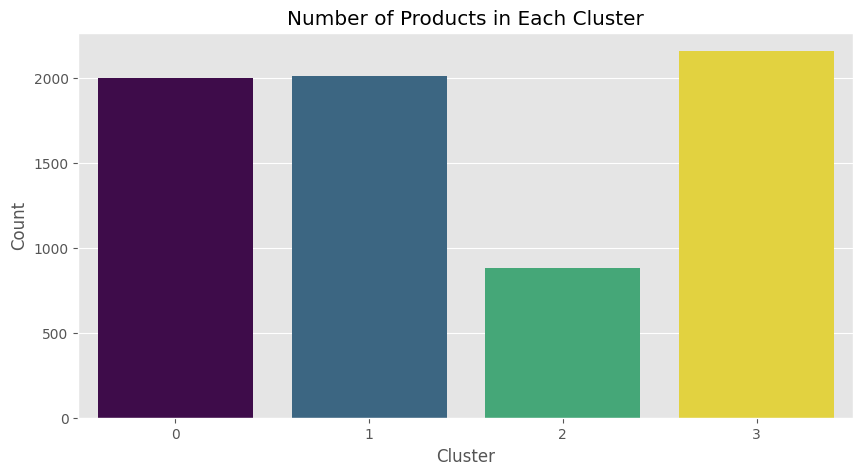

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=products, x='cluster', hue='cluster', palette='viridis', legend=False)
plt.title('Number of Products in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

At first glance, we can see that cluster number 2 contains significantly fewer products compared to the other clusters (approximately half the number). The distribution of products in the remaining clusters appears to be more balanced, with the counts being relatively similar across clusters.

This imbalance in cluster 2 could indicate that the products in this cluster share more specific or unique features, leading to fewer products being grouped together.

### Visualizing Product Titles with Word Clouds

To better understand the most frequent words and themes in each cluster, we will generate word clouds for the product titles in each cluster. Word clouds provide a visual representation of the most common words, where the size of each word corresponds to its frequency within the cluster.

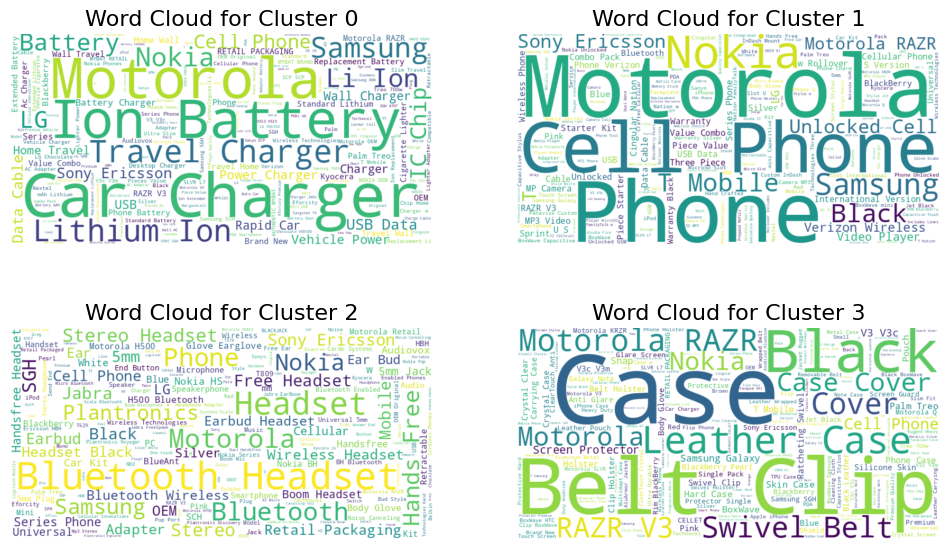

In [116]:
from wordcloud import WordCloud

products = products.sort_values(by='cluster', ascending=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.flatten()

for i, cluster in enumerate(products['cluster'].unique()):
    text = ' '.join(products[products['cluster'] == cluster]['product_title'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Word Cloud for Cluster {cluster}', fontsize=16)

plt.show()


- **Cluster 0**: This cluster includes terms like `Car Charger`, `Battery`, `Travel Charger`, `Ion Battery`, `Lithium Ion`, and `Li Ion`. Based on these words, we can categorize this cluster as **"Charging Accessories"**. This suggests that the products in this cluster are related to various types of chargers and batteries.

- **Cluster 1**: Common terms in this cluster include `Nokia`, `Motorola`, `Cell Phone`, `Phone`, `T-Mobile`, and `Samsung`. These words indicate that this cluster is likely related to **"Mobile Phones"**. Products in this cluster may be smartphones or related accessories from popular brands.

- **Cluster 2**: The frequent words here are `Bluetooth Headset`, `Bluetooth`, `Headset`, `Free Headset`, `Hands Free`, and `Plantronics`. Based on this, we can label this cluster as **"Bluetooth Headsets"**. It seems that the products in this cluster are primarily Bluetooth headsets and hands-free accessories.

- **Cluster 3**: This cluster contains words like `Case`, `Cover`, `Case Cover`, `Belt`, `Leather`, and `Swivel Belt`. We can categorize this cluster as **"Phone Cases and Covers"**. Products in this cluster are likely to be protective cases, covers, and belt clips for mobile phones, particularly those made from leather or designed for specific phone models.

## Recommendation System

In this section, we will build a recommendation system that suggests products based on user reviews and sentiment. The `RecommendationSystem` class uses a pre-trained `SBERT` model (sentence-transformers/all-MiniLM-L6-v2) to generate embeddings for each review. These embeddings are then indexed using `FAISS`, which allows for efficient similarity search based on cosine distance.

The process involves the following steps:
1. **Encoding Reviews**: We encode the review text into vector embeddings using the `SentenceTransformer` model.
2. **FAISS Indexing**: The embeddings are normalized and indexed using FAISS to enable fast similarity search.
3. **Product Recommendation**: For each user, we calculate the similarity between their reviews and other reviews to recommend products. The final recommendations are based on both sentiment and cosine distance between embeddings.

##### How Does it Work?

The algorithm is designed to identify reviews from other users that are similar to the user's own reviews. The scoring system for recommendations combines the **sentiment score** and the **cosine distance** between the user's review embeddings and the closest reviews from other users. The final score for each product is obtained by summing these values.

- For each product recommendation, the model multiplies the **sentiment score** (`POSITIVE` = 1, `NEGATIVE` = -1) by the **cosine distance** of the top **k** closest reviews from other users.
- This approach ensures that the system prioritizes reviews with positive sentiment and smaller cosine distances, making the recommendations both highly relevant and well-reviewed.

In [ ]:
from src import RecommendationSystem

rec_system = RecommendationSystem(device=config.DEVICE, model_name=config.EMBEDDING_MODEL, df=sentiment) 
rec_system.encode(batch_size=128)
recommendations = rec_system.recommend(k=200)

# Save the results to a CSV file in case of losing session variables
recommendations.to_csv(config.RECOMMENDATION_CSV, index=False)

Processing batches: 100%|██████████| 594/594 [23:11<00:00,  2.34s/batch]


In [92]:
sentiment['text'] = sentiment['text'].str.wrap(60)

In [19]:
sentiment = pd.read_csv(config.SENTIMENT_CSV)
recommendations = pd.read_csv(config.RECOMMENDATION_CSV)

In [20]:
print(sentiment.iloc[5].to_markdown())

|               | 5                                                                                                                                                                        |
|:--------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| product_id    | B000JDY0U4                                                                                                                                                               |
| product_title | Motorola Phone Tools 4.0 Software CD (no Cables included) for Motorola Model Phones                                                                                      |
| product_price | 5.95                                                                                                                                                                     |
| user_id       | A0240495330JKS21W63UP                

### Example User's Recommendations

In this example, we display a user's product recommendations along with the most relevant reviews that were considered for the recommendations. 

In [ ]:
i = 5
user_id = recommendations['user_id'].iloc[i]

print("\nUser Opinions:")
print(sentiment[sentiment['user_id'] == user_id][['product_id', 'user_id', 'sentiment', 'summary', 'text']].to_markdown())

recommended_reviews = []
for idx, review_id in enumerate(recommendations['similar_id'].iloc[i]):
    similarity_score = recommendations['similar_val'].iloc[i][idx]

    review_details = sentiment.loc[review_id, ['product_id', 'sentiment', 'summary', 'text']]
    review_details = review_details.to_frame().T
    review_details['cosine_distance'] = similarity_score

    recommended_reviews.append(review_details)

recommended_reviews_df = pd.concat(recommended_reviews, ignore_index=True)
recommended_reviews_df = recommended_reviews_df[['product_id', 'sentiment', 'cosine_distance', 'summary', 'text']]

recommended_reviews_df['text'] = recommended_reviews_df['text'].str.wrap(60)
print("\nRecommended Product Reviews with the Smallest Cosine Distances:")
print(recommended_reviews_df.to_markdown())


User Opinions:
|    | product_id   | user_id               | sentiment   | summary                                        | text                                                                                                                                                                     |
|---:|:-------------|:----------------------|:------------|:-----------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  5 | B000JDY0U4   | A0240495330JKS21W63UP | NEGATIVE    | no clear install instructions, flaky operation | The package contained only the CD, nothing else. I had to search the internet to find out how to install and use it. Once I had it figure out it works most of the time. |
No valid recommended reviews found.


This user was fighting with no instructions, what made him hard to set up and use the product. 

### Visualization of Cosine Distance Distribution

The histogram below illustrates the distribution of cosine distances among the recommended reviews. A lower cosine distance indicates higher similarity between the user's review embeddings and those of other users, which helps in refining product recommendations.

In [ ]:
all_distances = np.concatenate(recommendations['similar_val'].values)

plt.figure(figsize=(6, 4))
plt.hist(all_distances, bins=20, color='royalblue', edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Distances in Recommended Reviews')
plt.show()

ValueError: zero-dimensional arrays cannot be concatenated

### Distribution of Product Recommendations

The bar chart below shows how frequently products are recommended. It helps in understanding the concentration of recommendations across different products.

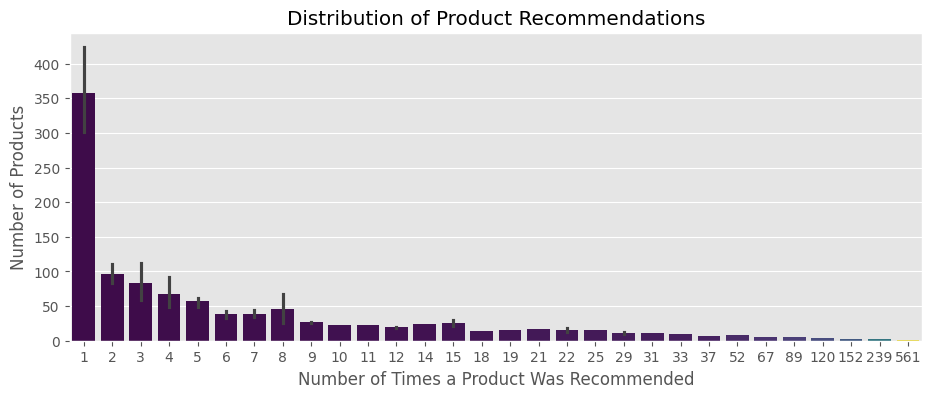

In [ ]:
product_distr = recommendations.groupby(by='recommendation')['recommendation'].count().reset_index(name='count')
product_distr = product_distr.groupby(by='count').count().reset_index()


plt.figure(figsize=(11, 4))
sns.barplot(data=product_distr, x='recommendation', y='count', hue='recommendation', palette='viridis', legend=False)

plt.title('Distribution of Product Recommendations')
plt.xlabel('Number of Times a Product Was Recommended')
plt.ylabel('Number of Products')

plt.show()


Almost 350 products were recommended only once, making this the most common case by a significant margin. As the number of times a product was recommended increases, the number of such products decreases (starting at 100 and ending at just one). Notably, there are even some products that were recommended 561 times. This could indicate that these products have numerous positive, well-detailed, and diverse reviews.